In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
def show_embeddings(vectors, y=None):
    
    # reduce dimensions with TSNE
    trans_vectors = TSNE(
        n_components=2, learning_rate='auto', init='random', perplexity=5
    ).fit_transform(vectors)
    
    # create legend if labels are known
    colors = None
    if y is not None:
        
        # create color map from unique labels
        labels = np.unique(y)
        label_idx = {k: v for k, v in zip(labels, range(len(labels)))}
        cmap = plt.cm.get_cmap('gist_rainbow', len(labels))
        colors = [cmap(label_idx[i]) for i in y]
        
        # add legend labels manually
        patches = [mpatches.Patch(color=cmap(i), label=label) for i, label in enumerate(labels)]
        plt.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.scatter(
        trans_vectors[:, 0],
        trans_vectors[:, 1],
        c=colors, alpha=1
    )
    return

def cutpad(arr):
    """
    Removes padding from array
    """
    return arr[arr != 0]

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df):
        values = df.groupby('id').apply(lambda x: x.values)
        self.data = [i[:, 2:].astype(float) for i in values]
        self.supplier = [i[0][0] for i in values]
        self.spec = [i[0][1] for i in values]
        
        assert np.all([
            np.all(
                df[df['id'] == self.spec[idx]].drop(['supplier', 'id'], 1).values
                == self.data[idx]
            )
            for idx in range(len(self.data))
        ]), 'ID спецификаций не соответствуют данным по спецификации'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float)

def pad_collate(batch):
    return pad_sequence(batch, batch_first=True, padding_value=0)

In [4]:
class Seq2SeqAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Seq2SeqAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        hidden = hidden.repeat(x.shape[1], 1, 1).permute(1, 0, 2)
        output, _ = self.decoder(hidden)
        return output

In [5]:
data = pd.read_csv('../data/final_data/data.csv')
dataset = TimeSeriesDataset(data)
dataloader = DataLoader(dataset, batch_size=8, collate_fn=pad_collate, shuffle=False)

In [9]:
model = Seq2SeqAutoencoder(10, 12, 1)

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [11]:
for epoch in range(500):
    for sequences in dataloader:
        output = model(sequences)
        loss = criterion(output, sequences)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # print(loss.item())

In [14]:
sequences.shape

torch.Size([8, 9, 10])

In [15]:
sequences[i, :, ]

tensor([18., 18., 20., 20., 20.,  0.,  0.,  0.,  0.])

In [60]:
data.columns[2:][4]

'price_change'

In [31]:
sequences[suuply_idx, :, feature]

tensor([0.2044, 0.3969, 0.6034, 0.7947, 1.0069, 0.0000, 0.0000, 0.0000, 0.0000])

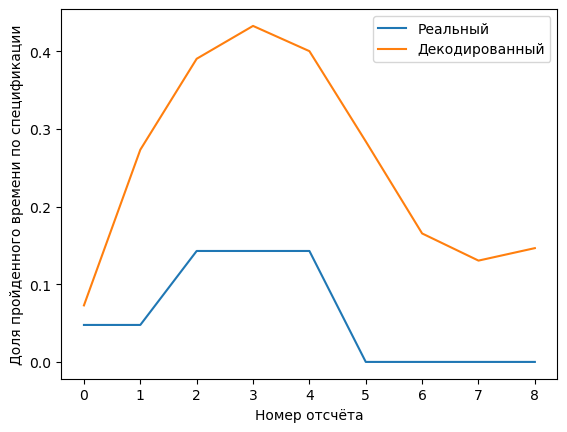

In [67]:
suuply_idx = 5
feature = 5

# plt.title('График поставок по спецификации')
plt.xlabel('Номер отсчёта')
plt.ylabel('Доля пройденного времени по спецификации')

plt.plot(sequences[suuply_idx, :, feature], label='Реальный')
plt.plot(output[suuply_idx, :, feature].detach(), label='Декодированный')

plt.legend()

plt.savefig('../figures/lateness_percentage.jpg', bbox_inches='tight')

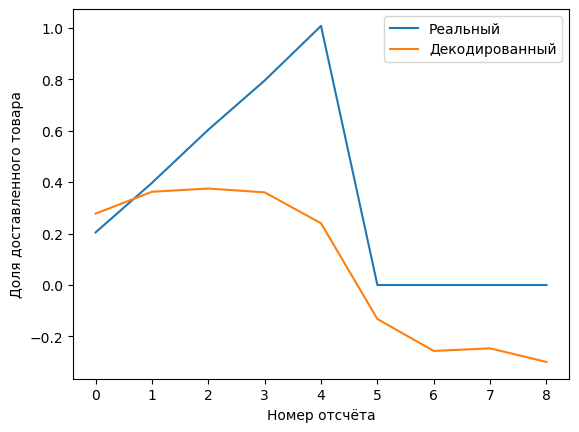

In [68]:
suuply_idx = 5
feature = 6

# plt.title('График поставок по спецификации')
plt.xlabel('Номер отсчёта')
plt.ylabel('Доля доставленного товара')

plt.plot(sequences[suuply_idx, :, feature], label='Реальный')
plt.plot(output[suuply_idx, :, feature].detach(), label='Декодированный')

plt.legend()

plt.savefig('../figures/weight_percentage.jpg', bbox_inches='tight')

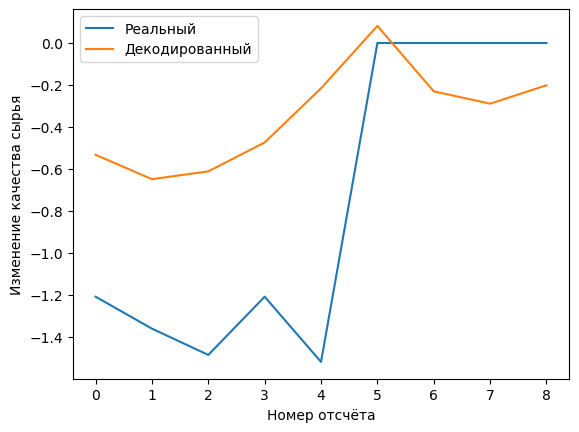

In [69]:
suuply_idx = 5
feature = 4

# plt.title('График поставок по спецификации')
plt.xlabel('Номер отсчёта')
plt.ylabel('Изменение качества сырья')

plt.plot(sequences[suuply_idx, :, feature], label='Реальный')
plt.plot(output[suuply_idx, :, feature].detach(), label='Декодированный')

plt.legend()

plt.savefig('../figures/price_change.jpg', bbox_inches='tight')

In [18]:
supplier_set = {
    'Барсукова Е.С. ИП Глава К(Ф)Х',
    'Донченко В.С. ИП Глава К(Ф)Х',
    'АГРОПРОМ ООО', 'ИНТЕРПРОМ ООО', 'ДОНСКИЕ ЗОРИ ООО'
}
indexes = np.where([
    (supplier in supplier_set) for supplier in dataset.supplier
])[0]

In [19]:
seqs = [dataset[i] for i in indexes]
suppliers = [dataset.supplier[i] for i in indexes]
embs = np.stack([model.encoder(seq.unsqueeze(0))[1][0].squeeze().detach().numpy() for seq in seqs])

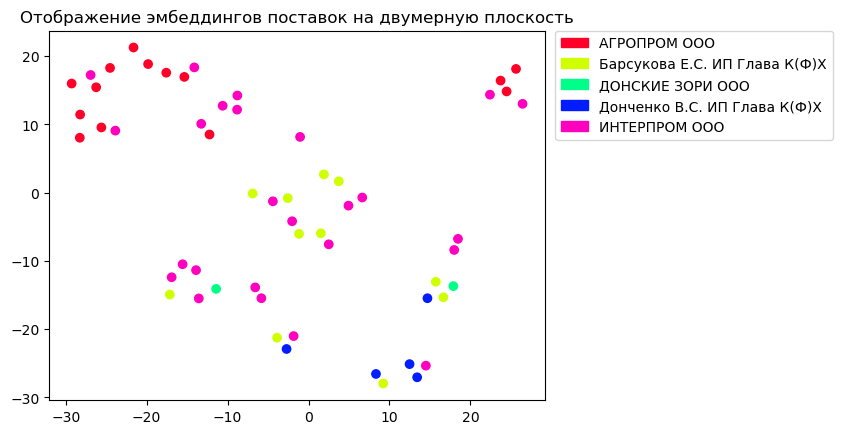

In [21]:
plt.title('Отображение эмбеддингов поставок на двумерную плоскость')
show_embeddings(embs, suppliers)
plt.savefig('../figures/tsne_spec_embedings.jpg', bbox_inches='tight')